# Project 2 - Coronavirus in Mexico

This project consist to estimate the SIR model with the most updated data from WHO.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PDEparams as pde
import cufflinks as cf
import plotly
import os
import math
import sympy as sy
from scipy import integrate
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, median_absolute_error
from scipy.integrate import odeint
from scipy.optimize import differential_evolution, minimize
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from scipy.integrate import odeint
print(__version__) # requires version >= 1.9.0

4.5.4


In [2]:
path = 'figsModelsMex'
if not os.path.isdir(path): os.makedirs(path)

In [3]:
# Saving figures
def save_fig(fig,figname):
    fig.savefig(os.path.join(path,figname+'.pdf'),format='pdf')

In [4]:
# Complete Database
data_who=pd.read_excel('COVID-19-geographic-disbtribution-worldwide.xlsx')
data_who.set_index('dateRep',inplace=True)
data_who.sort_values(by='dateRep',inplace=True)

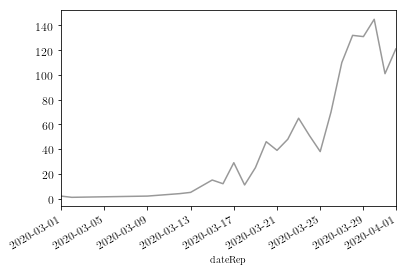

In [5]:
# Mexico Database
shortMex=data_who[data_who.countriesAndTerritories=='Mexico']['cases'].loc['2020-03-01':]
shortMex.plot()

In [6]:
tdf=range(len(shortMex))
df=pd.DataFrame({'t':range(len(shortMex)),'I':shortMex/(10**9)},columns=['t','I'])

In [7]:
#For ploting
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

### Initial conditions

In [8]:
def init_s():
    return 1-init_i()

def init_sd():
    return 0

def init_e():
    return 0
    
def init_a():
    return 0

def init_id():
    return 0

def init_i():
    return df['I'][0]

def init_r():
    return 0


### 1. SIR model:

$$\begin{align}
\frac{\mathrm{d} S}{\mathrm{d} t} &= -\beta\, \frac{SI}{N}\\
\frac{\mathrm{d} I}{\mathrm{d} t} &= \beta\, \frac{SI}{N} - \gamma\,I\\
\frac{\mathrm{d} R}{\mathrm{d} t} &= \gamma\,I
\end{align}$$


Susceptible -> Infected -> Recovered

$$\begin{align}
\beta &= \text{Contact Rate } \times \text{ Probability of Transmission}\\
\sigma &= \text{Incubation Rate}\\
\gamma &= \text{Recovery Rate}
\end{align}$$

Incubation Period: 1-14 Days, most commonly 5 days (WHO)

In [10]:
#Model
def sir(X,t,b,g):
    s,i,r=X
    
    ds=-b*(s*i)
    di=b*(s*i)-g*i
    dr=g*i
    return[ds,di,dr]

def sirm(X,t,b,g,m):
    s,i,r=X
    
    ds=-b*(s*i)
    di=b*(s*i)-g*i-m*i
    dr=g*i
    return[ds,di,dr]

In [11]:
#Numeric solution of the model
def sol_sir(init,t,b,g):
    sol=odeint(sir,init,t,args=(b,g))
    return(sol)

def sol_sirm(init,t,b,g,m):
    sol=odeint(sirm,init,t,args=(b,g,m))
    return(sol)

In [12]:
#Parameter estimation
my_sir=pde.PDEmodel(df,sir,[init_s,init_i,init_r],bounds=[(0.3,2),(1/14,1/5)],
                   param_names=[r'$b$', r'$g$'], nvars=3, ndims=0, nreplicates=1, obsidx=[1], outfunc=None)

In [13]:
#Parameter estimation
my_sirm=pde.PDEmodel(df,sirm,[init_s,init_i,init_r],bounds=[(0.3,2),(1/14,1/5),(0.001,0.3)],
                   param_names=[r'$b$', r'$g$',r'$m$'], nvars=3, ndims=0, nreplicates=1, obsidx=[1], outfunc=None)

In [14]:
my_sir.fit()

        $b$       $g$
0  0.357618  0.169533


In [15]:
my_sirm.fit()

        $b$       $g$       $m$
0  0.482471  0.102204  0.192145


In [16]:
my_sir.best_params

,$b$,$g$
0,0.357618,0.169533


In [17]:
my_sirm.best_params


,$b$,$g$,$m$
0,0.482471,0.102204,0.192145


In [18]:
my_sir.best_error

6.157570744838375e-16

In [19]:
my_sirm.best_error

6.157552695786656e-16

In [20]:
bestPars_sir=my_sir.best_params
bBsir=bestPars_sir['$b$'][0]
gBsir=bestPars_sir['$g$'][0]

In [21]:
bestPars_sirm=my_sirm.best_params
bBsirm=bestPars_sirm['$b$'][0]
gBsirm=bestPars_sirm['$g$'][0]
mBsirm=bestPars_sirm['$m$'][0]

In [22]:
bestSol=odeint(sir,[init_s(),init_i(),init_r()],tdf,args=(bBsir,gBsir))
#sol=odeint(sir,[shortMex.sum(axis=0),1,0],tMex,args=(bB,gB))
S=bestSol.T[0]
I=bestSol.T[1]
R=bestSol.T[2]


In [23]:
bestSolm=odeint(sirm,[init_s(),init_i(),init_r()],tdf,args=(bBsirm,gBsirm,mBsirm))
#sol=odeint(sir,[shortMex.sum(axis=0),1,0],tMex,args=(bB,gB))
Sm=bestSolm.T[0]
Im=bestSolm.T[1]
Rm=bestSolm.T[2]


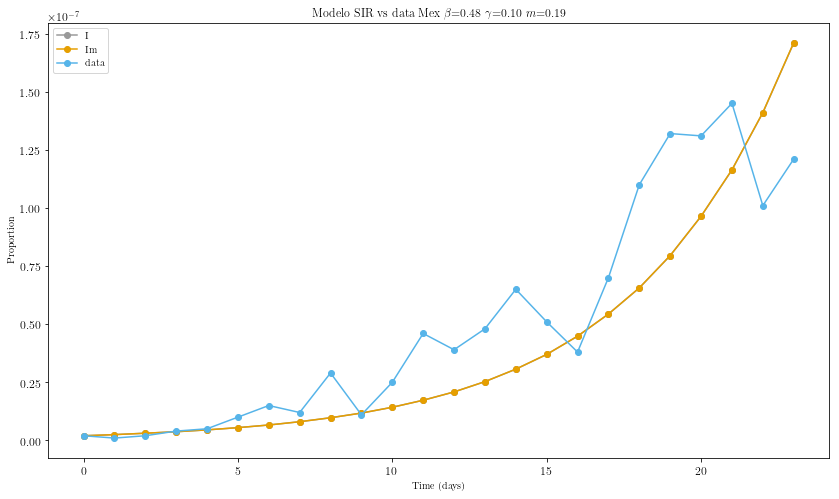

In [24]:
fig1,ax1=plt.subplots(1,1,figsize=(14,8))
ax1.plot(tdf,I,'-o',label='I')
ax1.plot(tdf,Im,'-o',label='Im')
ax1.plot(tdf,df['I'],'-o',label='data')
ax1.set_title('Modelo SIR vs data Mex '+r'$\beta$='+r'%0.2f'%bBsirm+ r' $\gamma$='+r'%0.2f'%gBsirm+r' $m$='+r'%0.2f'%mBsirm)
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Proportion')
ax1.legend()

### 2. SEIR model (Latency)

In [25]:
def seir(X,t,b,eta,g):
    s,e,i,r=X
    
    ds=-b*(s*i)
    de=b*(s*i)-eta*e
    di=eta*e-g*i
    dr=g*i
    return[ds,de,di,dr]

def seirm(X,t,b,eta,g,m):
    s,e,i,r=X
    
    ds=-b*(s*i)
    de=b*(s*i)-eta*e
    di=eta*e-g*i-m*i
    dr=g*i
    return[ds,de,di,dr]

In [26]:
def sol_seir(init,t,b,eta,g):
    sol=odeint(seir,init,t,args=(b,eta,g))
    return(sol)

def sol_seirm(init,t,b,eta,g,m):
    sol=odeint(seirm,init,t,args=(b,eta,g,m))
    return(sol)

In [27]:
my_seir=pde.PDEmodel(df,seir,[init_s,init_e,init_i,init_r],bounds=[(0.3,2),(1/14,1/5),(1/14,1/5)],
                   param_names=[r'$b$', r'$eta$',r'$g$'], nvars=4, ndims=0, nreplicates=1, obsidx=[2], outfunc=None)

In [28]:
my_seirm=pde.PDEmodel(df,seirm,[init_s,init_e,init_i,init_r],bounds=[(0.3,2),(1/14,1/5),(1/14,1/5),(0.001,0.3)],
                   param_names=[r'$b$', r'$eta$',r'$g$',r'$m$'], nvars=4, ndims=0, nreplicates=1, obsidx=[2], outfunc=None)

In [29]:
%%time
my_seir.fit()

        $b$     $eta$       $g$
0  0.568903  0.192063  0.071653
Wall time: 641 ms


In [30]:
%%time
my_seirm.fit()

        $b$     $eta$       $g$       $m$
0  0.564751  0.199257  0.072731  0.002483
Wall time: 2.57 s


In [31]:
my_seir.best_params

,$b$,$eta$,$g$
0,0.568903,0.192063,0.071653


In [32]:
my_seirm.best_params

,$b$,$eta$,$g$,$m$
0,0.564751,0.199257,0.072731,0.002483


In [33]:
my_seir.best_error

7.233848374790644e-16

In [34]:
my_seirm.best_error

7.225348313332751e-16

In [35]:
bestPars_seir=my_seir.best_params
bBseir=bestPars_seir['$b$'][0]
eBseir=bestPars_seir['$eta$'][0]
gBseir=bestPars_seir['$g$'][0]

In [36]:
bestPars_seirm=my_seirm.best_params
bBseirm=bestPars_seirm['$b$'][0]
eBseirm=bestPars_seirm['$eta$'][0]
gBseirm=bestPars_seirm['$g$'][0]
mBseirm=bestPars_seirm['$m$'][0]

In [37]:
bestSol_seir=odeint(seir,[init_s(),init_e(),init_i(),init_r()],tdf,args=(bBseir,eBseir,gBseir))
Sseir=bestSol_seir.T[0]
Eseir=bestSol_seir.T[1]
Iseir=bestSol_seir.T[2]
Rsair=bestSol_seir.T[3]

In [38]:
bestSol_seirm=odeint(seirm,[init_s(),init_e(),init_i(),init_r()],tdf,args=(bBseirm,eBseirm,gBseirm,mBseirm))
Sseirm=bestSol_seirm.T[0]
Eseirm=bestSol_seirm.T[1]
Iseirm=bestSol_seirm.T[2]
Rseirm=bestSol_seirm.T[3]



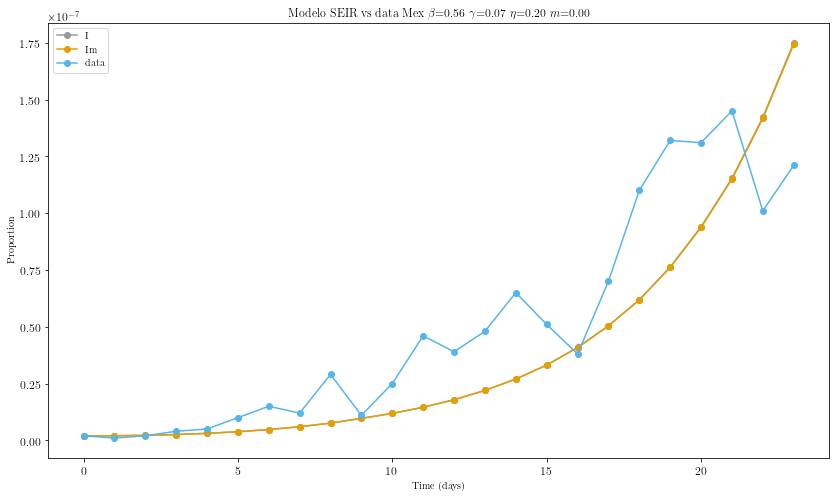

In [39]:
fig2,ax2=plt.subplots(1,1,figsize=(14,8))
ax2.plot(tdf,Iseir,'-o',label='I')
ax2.plot(tdf,Iseirm,'-o',label='Im')
ax2.plot(tdf,df['I'],'-o',label='data')
ax2.set_title('Modelo SEIR vs data Mex '+r'$\beta$='+r'%0.2f'%bBseirm+ r' $\gamma$='+r'%0.2f'%gBseirm+r' $\eta$='+r'%0.2f'%eBseirm+r' $m$='+r'%0.2f'%mBseirm)
ax2.set_xlabel('Time (days)')
ax2.set_ylabel('Proportion')
ax2.legend()

### 3. SAIR (Assymptomatic)

In [40]:
def sair(X,t,ba,bi,p,g):
    s,a,i,r=X
    
    ds=-(ba*a+bi*i)*s
    da=p*(ba*a*s+bi*i*s)-g*a
    di=(1-p)*(ba*a*s+bi*i*s)-g*i
    dr=g*i+g*a
    return[ds,da,di,dr]

def sairm(X,t,ba,bi,p,g,m):
    s,a,i,r=X
    
    ds=-(ba*a+bi*i)*s
    da=p*(ba*a*s+bi*i*s)-g*a
    di=(1-p)*(ba*a*s+bi*i*s)-g*i-m*i
    dr=g*i+g*a
    return[ds,da,di,dr]


In [41]:
def sol_sair(init,t,ba,bi,p,g):
    sol=odeint(sair,init,t,args=(ba,bi,p,g))
    return(sol)

def sol_sairm(init,t,ba,bi,p,g,m):
    sol=odeint(sair,init,t,args=(ba,bi,p,g,m))
    return(sol)

In [42]:
my_sair=pde.PDEmodel(df,sair,[init_s,init_a,init_i,init_r],bounds=[(0.3,2),(0.3,2),(0.1,0.9),(1/14,1/5)],
                   param_names=[r'$ba$', r'$bi$',r'$p$',r'$g$'], nvars=4, ndims=0, nreplicates=1, obsidx=[2], outfunc=None)

In [43]:
my_sairm=pde.PDEmodel(df,sairm,[init_s,init_a,init_i,init_r],bounds=[(0.3,2),(0.3,2),(0.1,0.9),(1/14,1/5),(0.001,0.3)],
                   param_names=[r'$ba$', r'$bi$',r'$p$',r'$g$',r'$m$'], nvars=4, ndims=0, nreplicates=1, obsidx=[2], outfunc=None)

In [44]:
%%time
my_sair.fit()

       $ba$      $bi$      $p$      $g$
0  0.308686  0.391231  0.10095  0.19093
Wall time: 1.68 s


In [45]:
%%time
my_sairm.fit()

       $ba$      $bi$       $p$       $g$       $m$
0  0.313312  0.408574  0.100788  0.194483  0.013729
Wall time: 3.68 s


In [46]:
my_sair.best_params

,$ba$,$bi$,$p$,$g$
0,0.308686,0.391231,0.10095,0.19093


In [47]:
my_sairm.best_params

,$ba$,$bi$,$p$,$g$,$m$
0,0.313312,0.408574,0.100788,0.194483,0.013729


In [48]:
my_sair.best_error

6.401122922791813e-16

In [50]:
my_sairm.best_error

6.411750375344447e-16

In [51]:
bestPars_sair=my_sair.best_params
baBsair=bestPars_sair['$ba$'][0]
biBsair=bestPars_sair['$bi$'][0]
pBsair=bestPars_sair['$p$'][0]
gBsair=bestPars_sair['$g$'][0]

In [52]:
bestPars_sairm=my_sairm.best_params
baBsairm=bestPars_sairm['$ba$'][0]
biBsairm=bestPars_sairm['$bi$'][0]
pBsairm=bestPars_sairm['$p$'][0]
gBsairm=bestPars_sairm['$g$'][0]
mBsairm=bestPars_sairm['$m$'][0]

In [53]:
bestSol_sair=odeint(sair,[init_s(),init_a(),init_i(),init_r()],tdf,args=(baBsair,biBsair,pBsair,gBsair))
Ssair=bestSol_sair.T[0]
Asair=bestSol_sair.T[1]
Isair=bestSol_sair.T[2]
Rsair=bestSol_sair.T[3]

In [54]:
bestSol_sairm=odeint(sairm,[init_s(),init_a(),init_i(),init_r()],tdf,args=(baBsairm,biBsairm,pBsairm,gBsairm,mBsairm))
Ssairm=bestSol_sairm.T[0]
Asairm=bestSol_sairm.T[1]
Isairm=bestSol_sairm.T[2]
Rsairm=bestSol_sairm.T[3]


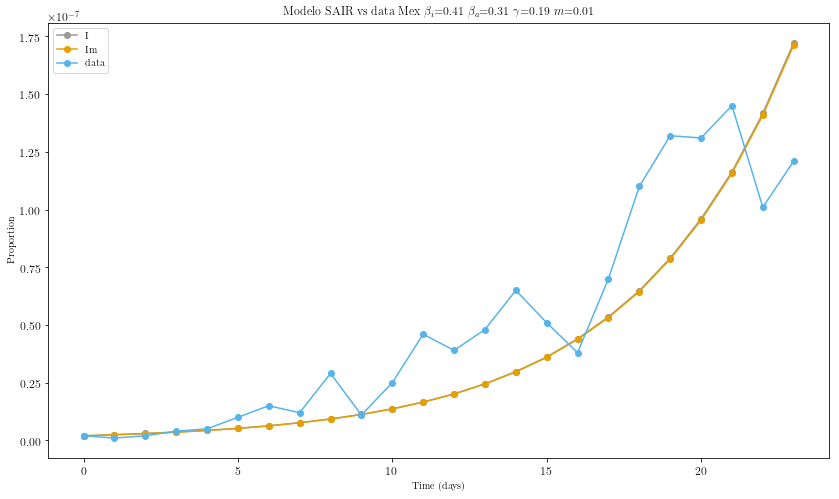

In [55]:
fig3,ax3=plt.subplots(1,1,figsize=(14,8))
ax3.plot(tdf,Isair,'-o',label='I')
ax3.plot(tdf,Isairm,'-o',label='Im')
ax3.plot(tdf,df['I'],'-o',label='data')
ax3.set_title('Modelo SAIR vs data Mex '+r'$\beta_i$='+r'%0.2f'%biBsairm+ r' $\beta_a$='+r'%0.2f'%baBsairm+r' $\gamma$='+r'%0.2f'%gBsairm+r' $m$='+r'%0.2f'%mBsairm)
ax3.set_xlabel('Time (days)')
ax3.set_ylabel('Proportion')
ax3.legend()

### 4. SEAIR 

In [56]:
def seair(X,t,ba,bi,eta,p,g):
    s,e,a,i,r=X
    
    ds=-(ba*a+bi*i)*s
    de=(ba*a+bi*i)*s-eta*e
    da=p*eta*e-g*a
    di=(1-p)*eta*e-g*i
    dr=g*i+g*a
    return[ds,de,da,di,dr]


def seairm(X,t,ba,bi,eta,p,g,m):
    s,e,a,i,r=X
    
    ds=-(ba*a+bi*i)*s
    de=(ba*a+bi*i)*s-eta*e
    da=p*eta*e-g*a
    di=(1-p)*eta*e-g*i-m*i
    dr=g*i+g*a
    return[ds,de,da,di,dr]

In [57]:
def sol_seair(init,t,ba,bi,eta,p,g):
    sol=odeint(seair,init,t,args=(ba,bi,eta,p,g))
    return(sol)

def sol_seairm(init,t,ba,bi,eta,p,g,m):
    sol=odeint(seairm,init,t,args=(ba,bi,eta,p,g,m))
    return(sol)

In [58]:
my_seair=pde.PDEmodel(df,seair,[init_s,init_e,init_a,init_i,init_r],bounds=[(0.3,2),(0.3,2),(1/14,1/5),(0.1,0.9),(1/14,1/5)],
                   param_names=[r'$ba$', r'$bi$',r'$eta$',r'$p$',r'$g$'], nvars=5, ndims=0, nreplicates=1, obsidx=[3], outfunc=None)

In [59]:
my_seairm=pde.PDEmodel(df,seairm,[init_s,init_e,init_a,init_i,init_r],bounds=[(0.3,2),(0.3,2),(1/14,1/5),(0.1,0.9),(1/14,1/5),(0.001,0.3)],
                   param_names=[r'$ba$', r'$bi$',r'$eta$',r'$p$',r'$g$',r'$m$'], nvars=5, ndims=0, nreplicates=1, obsidx=[3], outfunc=None)

In [60]:
%%time
my_seair.fit()

       $ba$      $bi$     $eta$       $p$       $g$
0  0.314711  0.743561  0.197463  0.100174  0.138006
Wall time: 3.7 s


In [61]:
%%time
my_seairm.fit()

       $ba$      $bi$     $eta$       $p$      $g$       $m$
0  0.328644  0.735649  0.199694  0.105928  0.13049  0.005156
Wall time: 9.63 s


In [62]:
my_seair.best_params

,$ba$,$bi$,$eta$,$p$,$g$
0,0.314711,0.743561,0.197463,0.100174,0.138006


In [63]:
my_seairm.best_params

,$ba$,$bi$,$eta$,$p$,$g$,$m$
0,0.328644,0.735649,0.199694,0.105928,0.13049,0.005156


In [64]:
my_seair.best_error

7.379813707940692e-16

In [66]:
my_seairm.best_error

7.381321589506402e-16

In [67]:
bestPars_seair=my_seair.best_params
baBseair=bestPars_seair['$ba$'][0]
biBseair=bestPars_seair['$bi$'][0]
eBseair=bestPars_seair['$eta$'][0]
pBseair=bestPars_seair['$p$'][0]
gBseair=bestPars_seair['$g$'][0]

In [68]:
bestPars_seairm=my_seairm.best_params
baBseairm=bestPars_seairm['$ba$'][0]
biBseairm=bestPars_seairm['$bi$'][0]
eBseairm=bestPars_seairm['$eta$'][0]
pBseairm=bestPars_seairm['$p$'][0]
gBseairm=bestPars_seairm['$g$'][0]
mBseairm=bestPars_seairm['$m$'][0]

In [69]:
bestSol_seair=odeint(seair,[init_s(),init_e(),init_a(),init_i(),init_r()],tdf,args=(baBseair,biBseair,eBseair,pBseair,gBseair))
Sseair=bestSol_seair.T[0]
Eseair=bestSol_seair.T[1]
Aseair=bestSol_seair.T[2]
Iseair=bestSol_seair.T[3]
Rseair=bestSol_seair.T[4]


In [70]:
bestSol_seairm=odeint(seairm,[init_s(),init_e(),init_a(),init_i(),init_r()],tdf,args=(baBseairm,biBseairm,eBseairm,pBseairm,gBseairm,mBseairm))
#sol=odeint(sir,[shortMex.sum(axis=0),1,0],tMex,args=(bB,gB))
Sseairm=bestSol_seairm.T[0]
Eseairm=bestSol_seairm.T[1]
Aseairm=bestSol_seairm.T[2]
Iseairm=bestSol_seairm.T[3]
Rseairm=bestSol_seairm.T[4]

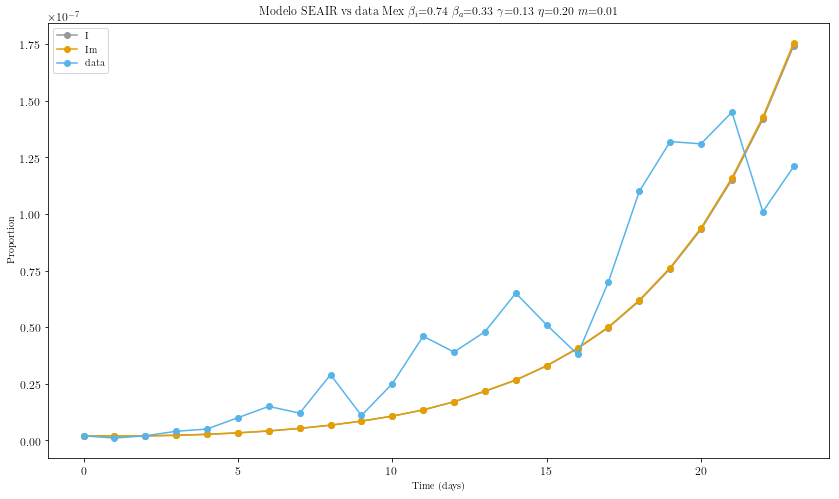

In [71]:
fig4,ax4=plt.subplots(1,1,figsize=(14,8))
ax4.plot(tdf,Iseair,'-o',label='I')
ax4.plot(tdf,Iseairm,'-o',label='Im')
ax4.plot(tdf,df['I'],'-o',label='data')
ax4.set_title('Modelo SEAIR vs data Mex '+r'$\beta_i$='+r'%0.2f'%biBseairm+ r' $\beta_a$='+r'%0.2f'%baBseairm+r' $\gamma$='+r'%0.2f'%gBseairm+r' $\eta$='+r'%0.2f'%eBseairm+r' $m$='+r'%0.2f'%mBseairm)
ax4.set_xlabel('Time (days)')
ax4.set_ylabel('Proportion')
ax4.legend()

### 5. SDIR 

In [72]:
def sdir(X,t,bi,p,g):
    S,SD,I,R=X
    
    dS=-(bi*I)*S
    dSD=-p*(bi*I)*SD
    dI=(bi*I)*S+p*(bi*I)*SD-g*I
    dR=g*I
    return[dS,dSD,dI,dR]

def sdirm(X,t,bi,p,g,m):
    S,SD,I,R=X
    
    dS=-(bi*I)*S
    dSD=-p*(bi*I)*SD
    dI=(bi*I)*S+p*(bi*I)*SD-(g+m)*I
    dR=g*I
    return[dS,dSD,dI,dR]

In [73]:
def sol_sdir(init,t,bi,p,g):
    sol=odeint(sdir,init,t,args=(bi,p,g))
    return(sol)

def sol_sdirm(init,t,bi,p,g,m):
    sol=odeint(sdir,init,t,args=(bi,p,g,m))
    return(sol)

In [74]:
my_sdir=pde.PDEmodel(df,sdir,[init_s,init_sd,init_i,init_r],bounds=[(0.3,2),(1,2),(1/14,1/5)],
                   param_names=[r'$bi$',r'$p$',r'$g$'], nvars=4, ndims=0, nreplicates=1, obsidx=[2], outfunc=None)

In [75]:
my_sdirm=pde.PDEmodel(df,sdirm,[init_s,init_sd,init_i,init_r],bounds=[(0.3,2),(1,2),(1/14,1/5),(0.001,0.3)],
                   param_names=[r'$bi$',r'$p$',r'$g$',r'$m$'], nvars=4, ndims=0, nreplicates=1, obsidx=[2], outfunc=None)

In [76]:
%%time
my_sdir.fit()

       $bi$       $p$       $g$
0  0.361629  1.666214  0.173491
Wall time: 531 ms


In [77]:
%%time
my_sdirm.fit()

       $bi$       $p$       $g$       $m$
0  0.486852  1.759334  0.166815  0.131919
Wall time: 650 ms


In [78]:
my_sdir.best_params

,$bi$,$p$,$g$
0,0.361629,1.666214,0.173491


In [79]:
my_sdirm.best_params

,$bi$,$p$,$g$,$m$
0,0.486852,1.759334,0.166815,0.131919


In [80]:
my_sdir.best_error

6.157563964021295e-16

In [82]:
my_sdirm.best_error

6.157551753201298e-16

In [83]:
bestPars_sdir=my_sdir.best_params
biBsdir=bestPars_sdir['$bi$'][0]
pBsdir=bestPars_sdir['$p$'][0]
gBsdir=bestPars_sdir['$g$'][0]

In [84]:
bestPars_sdirm=my_sdirm.best_params
biBsdirm=bestPars_sdirm['$bi$'][0]
pBsdirm=bestPars_sdirm['$p$'][0]
gBsdirm=bestPars_sdirm['$g$'][0]
mBsdirm=bestPars_sdirm['$m$'][0]

In [85]:
bestSol_sdir=odeint(sdir,[init_s(),init_sd(),init_i(),init_r()],tdf,args=(biBsdir,pBsdir,gBsdir))
Ssdir=bestSol_sdir.T[0]
SDsdir=bestSol_sdir.T[1]
Isdir=bestSol_sdir.T[2]
Rsdir=bestSol_sdir.T[3]

In [86]:
bestSol_sdirm=odeint(sdirm,[init_s(),init_sd(),init_i(),init_r()],tdf,args=(biBsdirm,pBsdirm,gBsdirm,mBsdirm))
Ssdirm=bestSol_sdirm.T[0]
SDsdirm=bestSol_sdirm.T[1]
Isdirm=bestSol_sdirm.T[2]
Rsdirm=bestSol_sdirm.T[3]

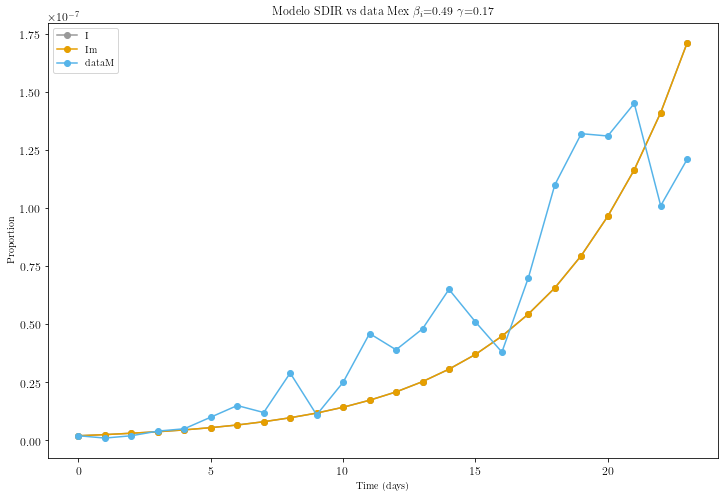

In [87]:
fig5,ax5=plt.subplots(1,1,figsize=(12,8))
ax5.plot(tdf,Isdir,'-o',label='I')
ax5.plot(tdf,Isdirm,'-o',label='Im')
ax5.plot(tdf,df['I'],'-o',label='dataM')
ax5.set_title('Modelo SDIR vs data Mex '+r'$\beta_i$='+r'%0.2f'%biBsdirm+r' $\gamma$='+r'%0.2f'%gBsdirm)
ax5.set_xlabel('Time (days)')
ax5.set_ylabel('Proportion')
ax5.legend()

### 6. SIGR

In [88]:
def sigr(X,t,bi,bg,p,g):
    S,I,IG,R=X
    
    dS=-(bi*I+bg*IG)*S
    dI=(1-p)*(bi*I+bg*IG)*S-g*I
    dIG=p*(bi*I+bg*IG)*S-g*IG
    dR=g*I+g*IG
    return[dS,dI,dIG,dR]

def sigrm(X,t,bi,bg,p,g,m):
    S,I,IG,R=X
    
    dS=-(bi*I+bg*IG)*S
    dI=(1-p)*(bi*I+bg*IG)*S-g*I
    dIG=p*(bi*I+bg*IG)*S-g*IG-m*IG
    dR=g*I+g*IG
    return[dS,dI,dIG,dR]


In [89]:
def sol_sigr(init,t,bi,bg,p,g):
    sol=odeint(sigr,init,t,args=(bi,bg,p,g))
    return(sol)

def sol_sigrm(init,t,bi,bg,p,g,m):
    sol=odeint(sigr,init,t,args=(bi,bg,p,g,m))
    return(sol)

In [90]:
my_sigr=pde.PDEmodel(df,sigr,[init_s,init_i,init_id,init_r],bounds=[(0.3,2),(0.3,2),(0.1,0.9),(1/14,1/5)],
                   param_names=[r'$bi$', r'$bg$',r'$p$',r'$g$'], nvars=4, ndims=0, nreplicates=1, obsidx=[1], outfunc=None)

In [96]:
my_sigrm=pde.PDEmodel(df,sigrm,[init_s,init_i,init_id,init_r],bounds=[(0.3,2),(0.3,2),(0.1,0.9),(1/14,1/5),(0.001,0.3)],
                   param_names=[r'$bi$', r'$bg$',r'$p$',r'$g$',r'$m$'], nvars=4, ndims=0, nreplicates=1, obsidx=[1], outfunc=None)

In [100]:
%%time
my_sigr.fit()

       $bi$      $bg$       $p$       $g$
0  0.331169  0.302928  0.100308  0.136538
Wall time: 3.48 s


In [105]:
%%time
my_sigrm.fit()

       $bi$      $bg$       $p$       $g$       $m$
0  0.307744  0.687204  0.153601  0.122965  0.299779
Wall time: 3.43 s


In [106]:
my_sigr.best_params

,$bi$,$bg$,$p$,$g$
0,0.331169,0.302928,0.100308,0.136538


In [110]:
my_sigrm.best_params

,$bi$,$bg$,$p$,$g$,$m$
0,0.307744,0.687204,0.153601,0.122965,0.299779


In [111]:
my_sigr.best_error

6.432568006042808e-16

In [113]:
my_sigrm.best_error

6.103887138175697e-16

In [114]:
bestPars_sigr=my_sigr.best_params
biBsigr=bestPars_sigr['$bi$'][0]
bgBsigr=bestPars_sigr['$bg$'][0]
pBsigr=bestPars_sigr['$p$'][0]
gBsigr=bestPars_sigr['$g$'][0]

In [115]:
bestPars_sigrm=my_sigrm.best_params
biBsigrm=bestPars_sigrm['$bi$'][0]
bgBsigrm=bestPars_sigrm['$bg$'][0]
pBsigrm=bestPars_sigrm['$p$'][0]
gBsigrm=bestPars_sigrm['$g$'][0]
mBsigrm=bestPars_sigrm['$m$'][0]

In [116]:
bestSol_sigr=odeint(sigr,[init_s(),init_i(),init_id(),init_r()],tdf,args=(biBsigr,bgBsigr,pBsigr,gBsigr))
Ssigr=bestSol_sigr.T[0]
Isigr=bestSol_sigr.T[1]
IGsigr=bestSol_sigr.T[2]
Rsigr=bestSol_sigr.T[3]

In [117]:
bestSol_sigrm=odeint(sigrm,[init_s(),init_i(),init_id(),init_r()],tdf,args=(biBsigrm,bgBsigrm,pBsigrm,gBsigrm,mBsigrm))
Ssigrm=bestSol_sigrm.T[0]
Isigrm=bestSol_sigrm.T[1]
IGsigrm=bestSol_sigrm.T[2]
Rsigrm=bestSol_sigrm.T[3]



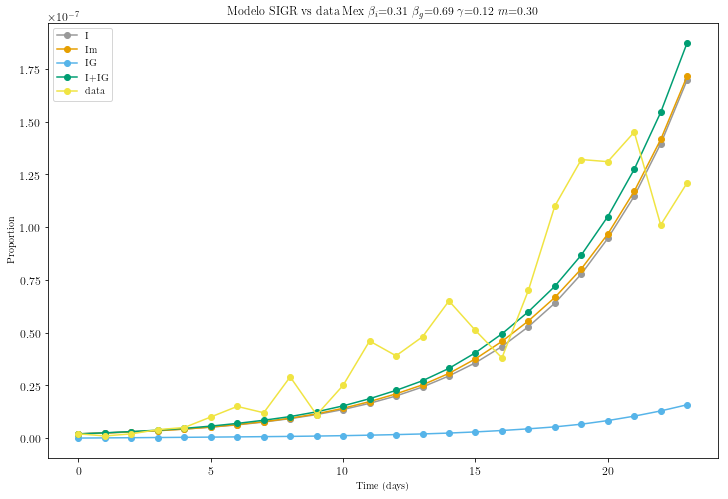

In [118]:
fig6,ax6=plt.subplots(1,1,figsize=(12,8))
ax6.plot(tdf,Isigr,'-o',label='I')
ax6.plot(tdf,Isigrm,'-o',label='Im')
ax6.plot(tdf,IGsigrm,'-o',label='IG')
ax6.plot(tdf,Isigrm+IGsigrm,'-o',label='I+IG')
ax6.plot(tdf,df['I'],'-o',label='data')
ax6.set_title('Modelo SIGR vs data Mex '+r'$\beta_i$='+r'%0.2f'%biBsigrm+r' $\beta_g$='+r'%0.2f'%bgBsigrm+r' $\gamma$='+r'%0.2f'%gBsigrm+r' $m$='+r'%0.2f'%mBsigrm)
ax6.set_xlabel('Time (days)')
ax6.set_ylabel('Proportion')
ax6.legend()

## Comparing approaches

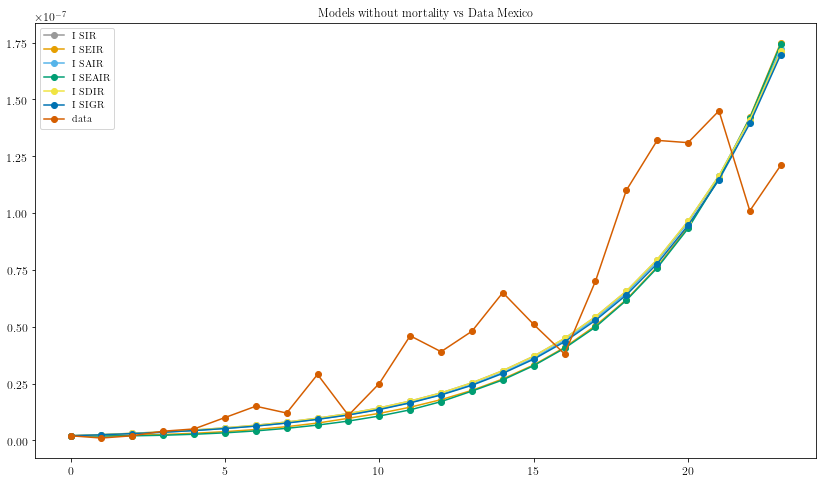

In [122]:
#Without mortality
figAll,axAll=plt.subplots(1,1,figsize=(14,8))
axAll.set_title('Models without mortality vs Data Mexico')
axAll.plot(tdf,I,'-o', label="I SIR")
axAll.plot(tdf,Iseir,'-o', label="I SEIR")
axAll.plot(tdf,Isair,'-o', label="I SAIR")
axAll.plot(tdf,Iseair,'-o', label="I SEAIR")
axAll.plot(tdf,Isdir,'-o', label="I SDIR")
axAll.plot(tdf,Isigr,'-o', label="I SIGR")
axAll.plot(tdf,df['I'],'-o', label="data")
axAll.legend(loc='best')

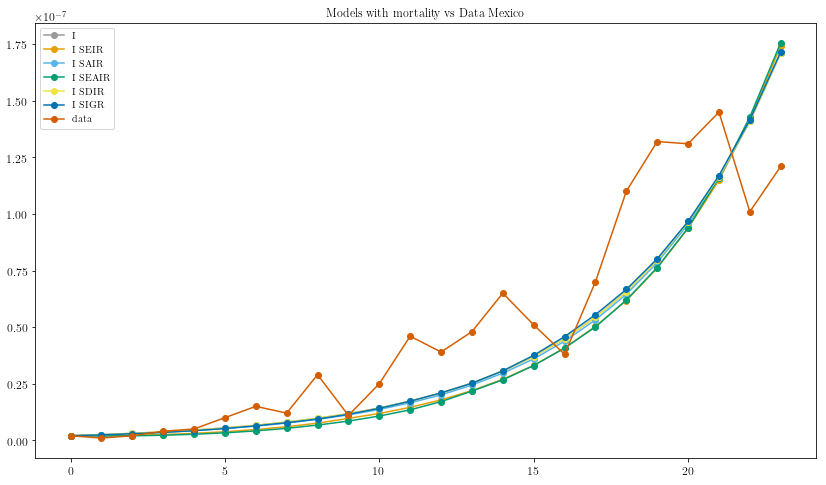

In [123]:
#With mortality
figAllm,axAllm=plt.subplots(1,1,figsize=(14,8))
axAllm.set_title('Models with mortality vs Data Mexico')
axAllm.plot(tdf,Im,'-o', label="I")
axAllm.plot(tdf,Iseirm,'-o', label="I SEIR")
axAllm.plot(tdf,Isairm,'-o', label="I SAIR")
axAllm.plot(tdf,Iseairm,'-o', label="I SEAIR")
axAllm.plot(tdf,Isdirm,'-o', label="I SDIR")
axAllm.plot(tdf,Isigrm,'-o', label="I SIGR")
axAllm.plot(tdf,df['I'],'-o', label="data")
axAllm.legend(loc='best')

## Comparing solutions of models

In [124]:
# Without mortality
t1=np.arange(0,200,1)

sol_sir=odeint(sir,[init_s(),init_i(),init_r()],t1,args=(bBsir,gBsir))
sol_seir=odeint(seir,[init_s(),init_e(),init_i(),init_r()],t1,args=(bBseir,eBseir,gBseir))
sol_sair=odeint(sair,[init_s(),init_a(),init_i(),init_r()],t1,args=(baBsair,biBsair,pBsair,gBsair))
sol_seair=odeint(seair,[init_s(),init_e(),init_a(),init_i(),init_r()],t1,args=(baBseair,biBseair,eBseair,pBseair,gBseair))
sol_sdir=odeint(sdir,[init_s(),init_sd(),init_i(),init_r()],t1,args=(biBsdir,pBsdir,gBsdir))
sol_sigr=odeint(sigr,[init_s(),init_i(),init_id(),init_r()],t1,args=(biBsigr,bgBsigr,pBsigr,gBsigr))


I1sir=sol_sir.T[1]
#1sir_gm=sol_sir_gm.T[1]
I1seir=sol_seir.T[2]
I1sair=sol_sair.T[2]
I1seair=sol_seair.T[3]
I1sdir=sol_sdir.T[2]
I1sigr=sol_sigr.T[1]

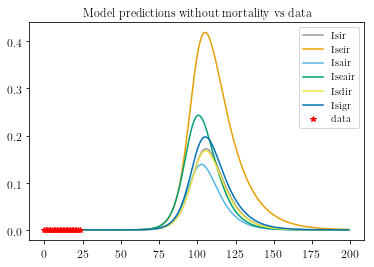

In [126]:
solsi=[I1sir,I1seir,I1sair,I1seair,I1sdir,I1sigr]
sol_labels=['Isir','Iseir','Isair','Iseair','Isdir','Isigr']

for soli,i in zip(solsi,range(len(solsi))):
    plt.plot(soli,label=sol_labels[i])
plt.plot(tdf,df['I'],'*',label='data',color='r')
plt.legend()
plt.title('Model predictions without mortality vs data')
plt.savefig(os.path.join(path,'predictions'+'.pdf'),format='pdf')

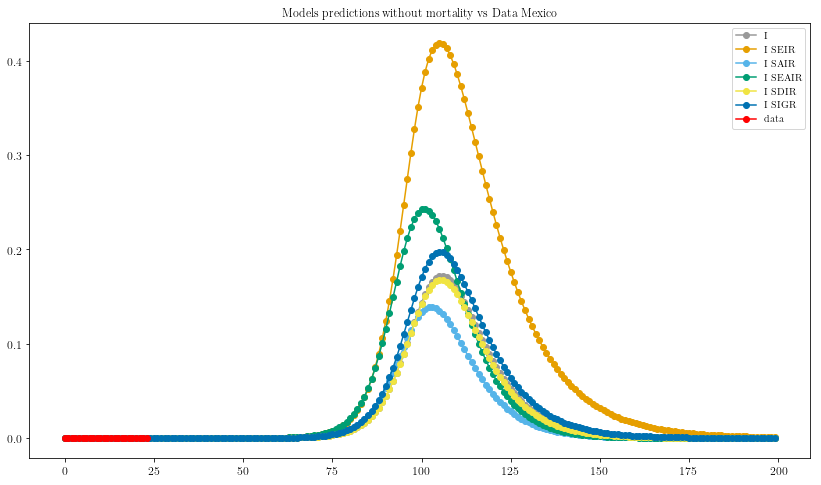

In [132]:
figAllP,axAllP=plt.subplots(1,1,figsize=(14,8))
axAllP.set_title('Models predictions without mortality vs Data Mexico')
axAllP.plot(I1sir,'-o', label="I")
axAllP.plot(I1seir,'-o', label="I SEIR")
axAllP.plot(I1sair,'-o', label="I SAIR")
axAllP.plot(I1seair,'-o', label="I SEAIR")
axAllP.plot(I1sdir,'-o', label="I SDIR")
axAllP.plot(I1sigr,'-o', label="I SIGR")
axAllP.plot(tdf,df['I'],'-o', color='r',label="data")
axAllP.legend(loc='best')

In [133]:
#With mortality
t1=np.arange(0,200,1)

sol_sirm=odeint(sirm,[init_s(),init_i(),init_r()],t1,args=(bBsirm,gBsirm,mBsirm))
sol_seirm=odeint(seirm,[init_s(),init_e(),init_i(),init_r()],t1,args=(bBseirm,eBseirm,gBseirm,mBseirm))
sol_sairm=odeint(sairm,[init_s(),init_a(),init_i(),init_r()],t1,args=(baBsairm,biBsairm,pBsairm,gBsairm,mBsairm))
sol_seairm=odeint(seairm,[init_s(),init_e(),init_a(),init_i(),init_r()],t1,args=(baBseairm,biBseairm,eBseairm,pBseairm,gBseairm,mBseairm))
sol_sdirm=odeint(sdirm,[init_s(),init_sd(),init_i(),init_r()],t1,args=(biBsdirm,pBsdirm,gBsdirm,mBsdirm))
sol_sigrm=odeint(sigrm,[init_s(),init_i(),init_id(),init_r()],t1,args=(biBsigrm,bgBsigrm,pBsigrm,gBsigrm,mBsigrm))


I1sirm=sol_sirm.T[1]
#1sir_gm=sol_sir_gm.T[1]
I1seirm=sol_seirm.T[2]
I1sairm=sol_sairm.T[2]
I1seairm=sol_seairm.T[3]
I1sdirm=sol_sdirm.T[2]
I1sigrm=sol_sigrm.T[1]

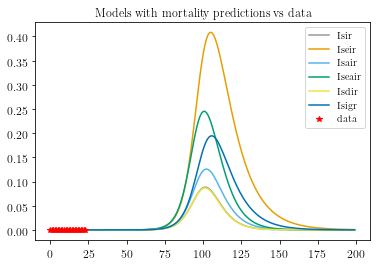

In [134]:
solsim=[I1sirm,I1seirm,I1sairm,I1seairm,I1sdirm,I1sigrm]
solm_labels=['Isir','Iseir','Isair','Iseair','Isdir','Isigr']

for solim,i in zip(solsim,range(len(solsi))):
    plt.plot(solim,label=solm_labels[i])
plt.plot(tdf,df['I'],'*',label='data',color='r')
plt.legend()
plt.title('Models with mortality predictions vs data')
plt.savefig(os.path.join(path,'predictionsMortality'+'.pdf'),format='pdf')

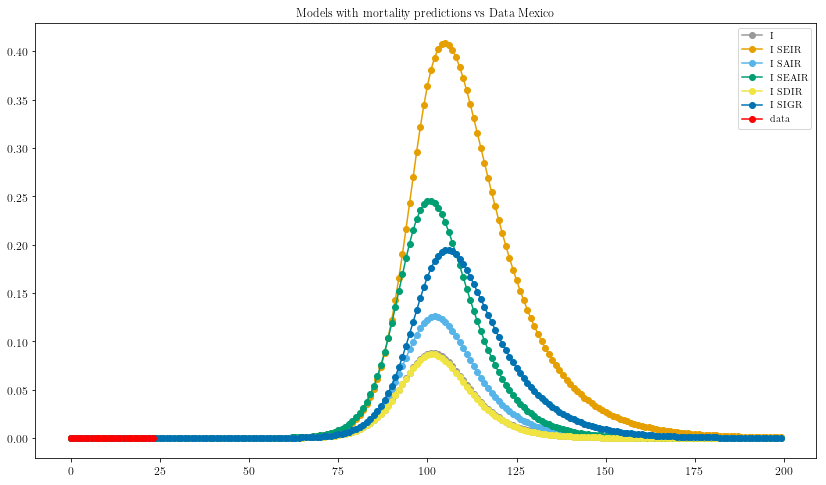

In [136]:
figAllmP,axAllmP=plt.subplots(1,1,figsize=(14,8))
axAllmP.set_title('Models with mortality predictions vs Data Mexico')
axAllmP.plot(I1sirm,'-o', label="I")
axAllmP.plot(I1seirm,'-o', label="I SEIR")
axAllmP.plot(I1sairm,'-o', label="I SAIR")
axAllmP.plot(I1seairm,'-o', label="I SEAIR")
axAllmP.plot(I1sdirm,'-o', label="I SDIR")
axAllmP.plot(I1sigrm,'-o', label="I SIGR")
axAllmP.plot(tdf,df['I'],'-o', color='r',label="data")
axAllmP.legend(loc='best')

### AIC MODEL COMPARISON

In [137]:
RSSv = [] 
RSSv = np.zeros(6)
AICv = []
AICv = np.zeros(6)

In [138]:
infec_sols=[Im,Iseirm,Isairm,Iseairm,Isdirm,Isigrm]
coef=[3,4,5,6,4,5]

In [139]:
for i,j in zip(infec_sols,range(len(infec_sols))):
        RSSv[j]=0.5*np.sum((df['I']-i)**2)
        AICv[j]=len(df['I'])*math.log10(RSSv[j]/len(df['I']))+ 2*coef[j]*len(df['I'])/(len(df['I'])-coef[j]-1)

In [140]:
grade = np.argmin(AICv)+1

In [141]:
AICv

array([-365.0789246 , -360.50684583, -358.52394802, -353.44832438,
       -362.17366304, -359.03683069])

In [142]:
def aic_order(aics):
    aics_ordered=sorted(aics)
    
    list_index=dict()
    
    for i in range(len(aics)):
        #list_index['d'+r'%0.f'%i]=aics.index([dist_ordered[i]])
        list_index['d'+r'%0.f'%i]=np.where(aics==aics_ordered[i])
    
    return(aics_ordered,list_index)

In [143]:
(aic_order(AICv))

([-365.0789246036041,
  -362.173663041251,
  -360.5068458254306,
  -359.0368306862402,
  -358.5239480210842,
  -353.4483243752703],
 {'d0': (array([0], dtype=int32),),
  'd1': (array([4], dtype=int32),),
  'd2': (array([1], dtype=int32),),
  'd3': (array([5], dtype=int32),),
  'd4': (array([2], dtype=int32),),
  'd5': (array([3], dtype=int32),)})

In [144]:
figs=[fig1,fig2,fig3,fig4,fig5,fig6,figAllP,figAllmP]
labels=['fig1','fig2','fig3','fig4','fig5','fig6','figAllP','figAllmP']

In [145]:
for fig,l in zip(figs,range(len(figs))):
    save_fig(fig,labels[l])
    